In [ ]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import os
import joblib
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
#save dataframe to csv
def save_to_csv(dataframe, file_name):
      path = '/content/drive/MyDrive/project_asteroid/train_test_split/'
      dataframe.to_csv(os.path.join(path, file_name), index=False)
  
## plotting feature importance
def plot_feature_imp(model, train_data, feature_set):
    """ function to plot feature importance"""
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.barplot(x=np.sort(model.feature_importances_)[::-1], y=train_data.columns)
    ax.set(xscale='log')
    ax.set_title(f'Feature Importance - {feature_set}')
    plt.show() 

In [ ]:
test = pd.read_csv('/content/test1.csv', header=None)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,Ceres (A801 AA),Ceres,N,N,3.33,0.12,939.4,964.4 x 964.2 x 891.8,0.09,9.07417,...,0.2142,2459920.37,1680.0,4.6,1.59,2.09,MBA,9520.0,0,0.43153


## Loading data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project_asteroid/asteroids_final.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,7,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.columns

Index(['full_name', 'name', 'neo', 'pha', 'H', 'G', 'diameter', 'extent',
       'albedo', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T',
       'H_sigma', 'diameter_sigma', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'per', 'per_y', 'moid', 'moid_jup', 'class',
       'data_arc', 'condition_code', 'rms'],
      dtype='object')

In [ ]:
df.iloc[:10, :].to_csv('/content/drive/MyDrive/test_cases/testcase')

### Feature Selection based on EDA studies

In [ ]:
# original dataset shape
df.shape

(139708, 37)

In [ ]:
# creating a new dataframe from master
dfe = df.copy()

- drop features - as inferred from the Missing Value review(>80% data insuffieciency), and other reasons like data irrelevance
- drop 'w', 'ma', 'om' as understood from EDA feature correlation and feature importance studies
- Top most important features - albedo, H, data_arc, 'ad', 'a', 'q', 'e', moid. Orbit class, neo, pha too have strong corrlation with diameter

In [ ]:
# dataframe dfe is a fresh copy from master df, 
# removing features owing to feature irrelevance and missing value analysis (missing>80% data)
dfe.drop(['full_name','name', 'extent', 'rot_per', 'G', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T',
       'H_sigma', 'diameter_sigma', 'per_y'], axis=1, inplace=True)

In [ ]:
# dropping features as inferred as irrelevant from EDA
dfe.drop([ 'w', 'ma', 'om'], axis=1, inplace=True)

Below is our to_drop list for our dataset

In [ ]:
to_drop_columns = ['full_name','name', 'extent', 'rot_per', 'G', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T',
       'H_sigma', 'diameter_sigma', 'per_y', 'w', 'ma', 'om']

In [ ]:
# columns in the dataset
dfe.columns

Index(['neo', 'pha', 'H', 'diameter', 'albedo', 'epoch', 'e', 'a', 'q', 'i',
       'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'class', 'data_arc',
       'condition_code', 'rms'],
      dtype='object')

In [ ]:
# checking shape of dataset dfe
dfe.shape

(139708, 20)

## Train Test Split

In [ ]:
# defining X, y
y = dfe.diameter
X = dfe.drop('diameter', axis=1)

To do a stratified splitting for the continuous target 'diameter', i am making use of verstack package tool:
- **verstack.stratified_continuous_split.scsplit**
- Reference - https://pypi.org/project/verstack/

In [ ]:
! pip install verstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.2 MB/s 
     |████████████████████████████████| 23.2 MB 92.5 MB/s 
     |████████████████████████████████| 2.0 MB 41.5 MB/s 
     |████████████████████████████████| 308 kB 46.7 MB/s 
     |████████████████████████████████| 23.9 MB 1.5 MB/s 
     |████████████████████████████████| 227 kB 49.1 MB/s 
     |████████████████████████████████| 155 kB 49.5 MB/s 
     |████████████████████████████████| 665.5 MB 21 kB/s 
     |████████████████████████████████| 1.3 MB 38.1 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 48.5 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 463 kB 34.3 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 45.8 MB/s 
     |███████████████████████████████

In [ ]:
#!pip install protobuf==3.20.*

In [ ]:
import verstack
verstack.__version__

'3.2.3'

Splitting data into train and test, with test_size of 0.3

In [ ]:
X.shape

(139708, 19)

In [ ]:
from verstack.stratified_continuous_split import scsplit
X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, test_size=0.3, random_state=0) #test_size default=0.3

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97795, 19), (41913, 19), (97795,), (41913,))

In [ ]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [ ]:
#save files
save_to_csv(X_train, 'X_train')
save_to_csv(X_test, 'X_test')
save_to_csv(y_train, 'y_train')
save_to_csv(y_test, 'y_test')

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_train')
X_test = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_test')

In [ ]:
X_train.shape, X_test.shape


((97795, 19), (41913, 19))

In [ ]:
y_train = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/y_train', squeeze=True)
y_test = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/y_test', squeeze=True)

In [ ]:
y_train.shape, y_test.shape

((97795,), (41913,))

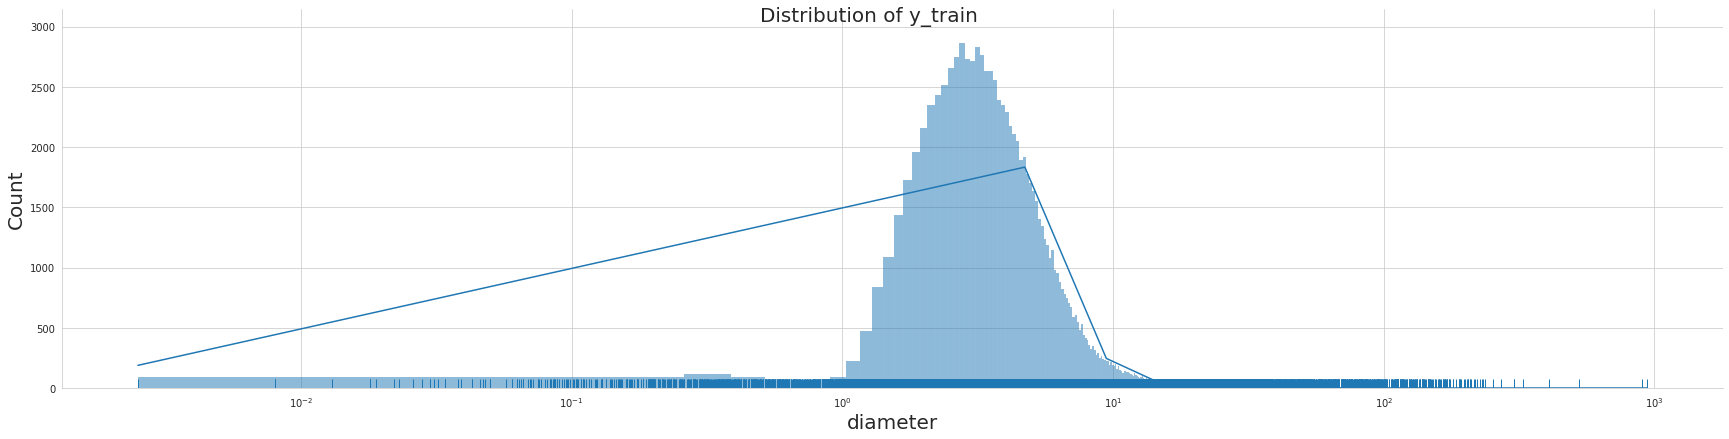

In [ ]:
#plotting y_train distribution
sns.set_style("whitegrid")
g = sns.displot(x=y_train, kde=True, rug=True, height=6, aspect=4)
g.set(xscale='log')
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of y_train", fontsize=20)
plt.show()


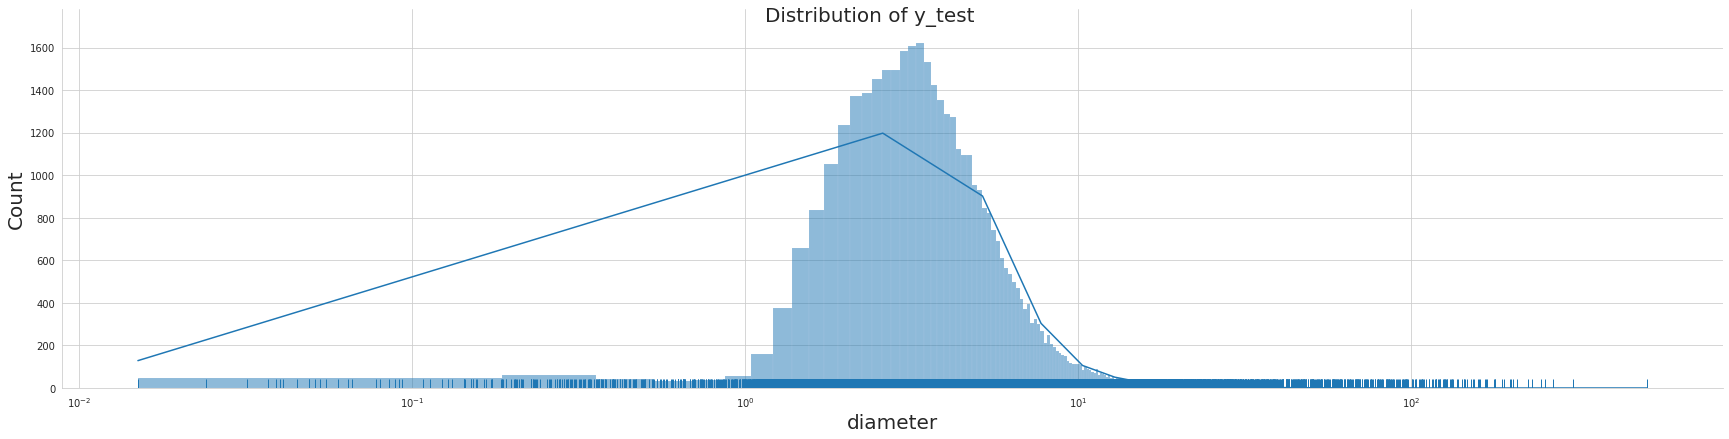

In [ ]:
# plotting y_test distribution
sns.set_style("whitegrid")
g = sns.displot(x=y_test, kde=True, rug=True, height=6, aspect=4)
g.set(xscale='log')
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of y_test", fontsize=20)
plt.show()


Observations:
- distribution of y_train and y_test looks similar


## Categorical Variables Encoding - one hot encoding

We have three categorical variables:
  - pha: 2 categories (Y/N)
  - neo: 2 categories (Y/N)
  - class: 11 categories of orbit classes

All three categories are nominal, so we will go with one hot encoding

In [ ]:
X_train =  pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_train')
X_test =  pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_test')
y_train = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/y_train', squeeze=True)
y_test = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/y_test', squeeze=True)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97795, 19), (41913, 19), (97795,), (41913,))

In [ ]:
# improting library
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_train.dtypes

neo                object
pha                object
H                 float64
albedo            float64
epoch             float64
e                 float64
a                 float64
q                 float64
i                 float64
ad                float64
n                 float64
tp                float64
per               float64
moid              float64
moid_jup          float64
class              object
data_arc          float64
condition_code      int64
rms               float64
dtype: object

In [ ]:
# getting hold of the categorical columns
cat_cols = X_train.dtypes[X_train.dtypes=='object'].index
num_cols = X_train.dtypes[(X_train.dtypes=='float64') | (X_train.dtypes=='int64') ].index

In [ ]:
cat_cols

Index(['neo', 'pha', 'class'], dtype='object')

In [ ]:
num_cols

Index(['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per',
       'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms'],
      dtype='object')

In [ ]:
X_train[cat_cols].head()

,neo,pha,class
0,N,N,MBA
1,N,N,MBA
2,N,N,MBA
3,N,N,MBA
4,N,N,MBA


In [ ]:
# applying one hot encoding
ohe = OneHotEncoder(drop='first')
ohe.fit(X_train[cat_cols])
X_train_cat_cols = ohe.transform(X_train[cat_cols]).toarray()
X_test_cat_cols = ohe.transform(X_test[cat_cols]).toarray()

In [ ]:
import pickle
pickle.dump(ohe, open('/content/drive/MyDrive/project_asteroid/train_test_split/ohe', 'wb'))

In [ ]:
ohe.get_feature_names_out()

array(['neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE',
       'class_CEN', 'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB',
       'class_TJN', 'class_TNO'], dtype=object)

We need to concatenate encoded Categorical columns with the numerical set

In [ ]:
X_train_encoded = np.hstack((X_train[num_cols].values, X_train_cat_cols))
X_test_encoded = np.hstack((X_test[num_cols].values, X_test_cat_cols))

In [ ]:
X_train_encoded.shape,  X_test_encoded.shape

((97795, 28), (41913, 28))

In [ ]:
# creating dataframes of these outputs
ncols = list(X_train[num_cols].columns)
ccols = list(ohe.get_feature_names_out())
ncols.extend(ccols)
print(ncols)

['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO']


In [ ]:
#converting into dataframes
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ncols)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ncols)

In [ ]:
X_train_encoded_df.head()

,H,albedo,epoch,e,a,q,i,ad,n,tp,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,14.73,0.100,2459800.5,0.0437,3.103,2.967,8.63,3.24,0.1803,2459704.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,17.33,0.071,2459800.5,0.1538,2.988,2.529,12.74,3.45,0.1908,2459459.77,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,14.40,0.207,2459800.5,0.0393,3.098,2.976,11.80,3.22,0.1808,2459605.94,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,13.67,0.178,2459800.5,0.1505,2.628,2.233,13.52,3.02,0.2313,2459501.23,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,13.74,0.077,2459800.5,0.1450,3.133,2.678,6.30,3.59,0.1778,2459220.69,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
save_to_csv(X_train_encoded_df, 'X_train_encoded_df')
save_to_csv(X_test_encoded_df, 'X_test_encoded_df')

### Correlation study with encoded independent features
Now that we have have X_train scaled and categoricaly encoded, lets have a look at the correlation between these transformed independent features

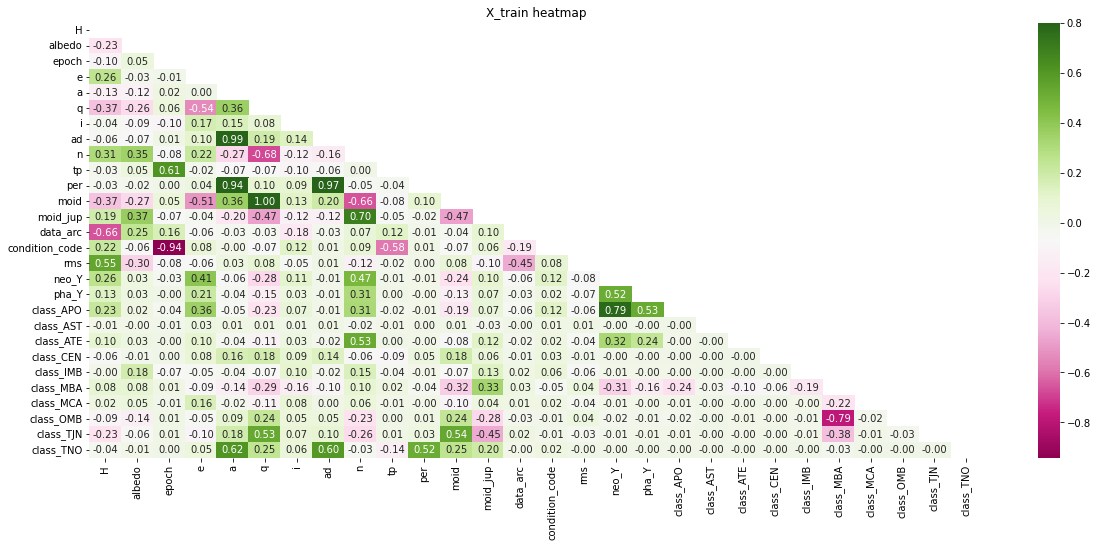

In [ ]:
#plotting heatmap for data correlation
corr_matrix =  X_train_encoded_df.corr()
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, vmax=0.8, annot=True, mask=mask, fmt='.2f', cmap="PiYG")
plt.title("X_train heatmap")
plt.show()

Observations:

- positive correlations:
  - class_TNO display strong positive correlation with 'a', 'ad', 'per'
  - class_TJN display positive correlation with 'q' and moid
  - class_ATE display positive correlation with 'n'
  - class_APO display high correlation with neo_y, and also with pha_y
  - pha_y display high correlation neo_y
  - neo_y display positive corelation with 'e' and 'n'
  - 'a' and 'ad' display high positive correlation
  - 'q' and 'moid' display high positive correlation
  - 'ad' and 'per' display high positive correlation
  - 'n' and 'moid_jupiter' display strong positive correlation 
  - epoch and 'tp' display strong positive correlation
  - 'H' and rms

- High/strong negative correlations observed between:
  - class_TJN and moid_jup
  - class_OMB and class_MBA
  - epoch and condition_code
  - 'tp' and condition_code
  - 'n' and moid
  - moid and moid_jupiter
  - 'e' and 'q'
  - 'H' and 'data_arc'
  - 'q' and 'n'
  - data_arc and rms
  - 'H' and data_arc 


## Missing value Imputation

In [ ]:
X_train_encoded_df.isnull().sum()[X_train_encoded_df.isnull().sum().values>0]

H           756
albedo      795
data_arc     19
dtype: int64

In [ ]:
X_test_encoded_df.isnull().sum()[X_test_encoded_df.isnull().sum().values>0]

H           358
albedo      344
data_arc      6
dtype: int64

### Discussion on coming up with a strategy to impute missing values for albedo, H, data-arc

#### 1. '**albedo**' - from our EDA, we know overall we have 0.8153% of missing data for the feature

In [ ]:
#let's look at X_train albedo statistics
print(f"'albedo' mean: {round(X_train_encoded_df.albedo.mean(), 2)}")
print(f"'albedo' median: {X_train_encoded_df.albedo.median()}")
albedo_stats_before_imputation = X_train_encoded_df[['albedo']].describe()

'albedo' mean: 0.13
'albedo' median: 0.078



- Domain-specific information:

  - Astronomical albedos are usually given by the IRAS minor planet survey[1] or the MSX minor planet survey[2] (available at the PDS).    These are geometric albedos. If there is no IRAS/MSX data a **rough average of 0.1** can be used. (Source: Source: https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics#Albedo)

  - Only a coarse estimation of size can be found from the object's magnitude because an assumption must be made for its albedo which is also not usually known for certain. The NASA near-Earth object program uses an **assumed albedo of 0.14** for this purpose.(Source: https://en.wikipedia.org/wiki/Potentially_hazardous_object#Size)
  - [commonly assumed albedo range for asteroid is between 0.05 - 0.25](http://www.physics.sfasu.edu/astro/asteroids/sizemagnitude.html)
  - Asteroids mainly fall into three categories - 
      - C-type: accounts for 75% of known asteroids, (albedo: 0.03-0.09)
      - S-type(): accounts for 17%
of known asteroids, (albedo: 0.10-0.22)
      - M-type: rest of the asteroids, (albedo: 0.10-0.18)
      https://nssdc.gsfc.nasa.gov/planetary/text/asteroids.txt
  -  Where an asteroid was not included in any of these satellites, the
diameter was estimated from the asteroid’s absolute magnitude H
using 𝐷𝑖𝑎𝑚𝑒𝑡𝑒𝑟 = 10(3.1295−0.5 log10 (𝑎)−0.2𝐻) **with an assumed albedo of a=0.1652** – (Bowell et al. 1989) at p. 551
    - https://arxiv.org/pdf/2010.06086.pdf
    - (Bowell et al. 1989) at p. 551



- Dataset Statistics info- 'albedo' feature mean and median value
    ```
    'albedo' mean: 0.13
    'albedo' median: 0.078
    ```

** caveat: [an error in the assumed albedo can result in a significantly erroneous diameter](https://cneos.jpl.nasa.gov/tools/ast_size_est.html)


---
---
**Imputation strategy**: albedo mean
- statistic mean 0.13 seems to closer domain value 0.14 used by NASA for NEO program. Also we have another domain speicfic mention of asumed value to be 0.16
- statistic median 0.078 goes well with C, S, M type based classes proportion and albedo range
- Based on above facts, seems reasonable to go with mean value of 0.13

#### 2. '**H**' absolute magnitude -  from our EDA, we know overall we have 0.7974% of missing data for the feature

In [ ]:
# total values missing
print(f"Total values missing for 'H': {X_train_encoded_df.H.isnull().sum()}")

#let's look at data statistic
print(f"'H' mean: {round(X_train_encoded_df.H.mean(), 2)}")
print(f"'H' median: {X_train_encoded_df.H.median()}")
H_stats_before_imputation = X_train_encoded_df[['H']].describe()

Total values missing for 'H': 756
'H' mean: 15.36
'H' median: 15.45


- Domain-specific information:

  - Most asteroids have irregular shapes (that is, very few are close to being spherical). However, the size (diameter of an equivalent sphere) of an asteroid can be estimated from its absolute magnitude H and an assumed geometric albedo
  - CNEOS, NASA- Asteroid Size Estimator - https://cneos.jpl.nasa.gov/tools/ast_size_est.html
     - https://www.boulder.swri.edu/clark/jssrpb04.pdf

- Data Statistics based info- 'H' feature mean and median value
    ```
    'H' mean: 15.35
    'H' median: 15.44
    ```

---
---
**Imputation strategy**: 
- Since 'diameter' is the target variable, we cannot apply the domain info of computing 'H' given diameter and albedo
- We had the observed this in CDF plots:
  - 80% of s1 is approx. <=22 absolute magnitude
  - 80% of s2 is approx. <=17 absolute magnitude
  - 80% of s3 is approx. <=14 absolute magnitude
  - 80% of s4 is approx. <=8 absolute magnitude
- mean and median values are closer
- We can try imputing with mean value and see how it works out

#### 3. **data_arc**	from our EDA, we know overall we have 0.0179% of missing data for the feature

data-arc span is number of days spanned by the data-arc

In [ ]:
print(f"data-arc span mean: {round(X_train.data_arc.mean(),2)} days")
print(f"data-arc span median: {round(X_train.data_arc.median(),2)} days")
print(f"data-arc span mean(yr): {round(X_train.data_arc.mean()/365,2)} years")
print(f"data-arc span median(yr): {round(X_train.data_arc.median()/365,2)} years")

data-arc span mean: 10139.52 days
data-arc span median: 8544.0 days
data-arc span mean(yr): 27.78 years
data-arc span median(yr): 23.41 years


In [ ]:
print(f"data_arc mean for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.mean()}")
print(f"data_arc median for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.median()}")
print(f"data_arc min for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.min()}")
print(f"data_arc max for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.max()}")

data_arc mean for near earth objects(neo): 6582.870601589103
data_arc median for near earth objects(neo): 5066.0
data_arc min for near earth objects(neo): 1.0
data_arc max for near earth objects(neo): 46582.0


In [ ]:
print(f"data_arc mean for not-neo: {X_train[X_train.neo=='N'].data_arc.mean()}")
print(f"data_arc median for not-neo: {X_train[X_train.neo=='N'].data_arc.median()}")
print(f"data_arc min for not-neo: {X_train[X_train.neo=='N'].data_arc.min()}")
print(f"data_arc max for not-neo: {X_train[X_train.neo=='N'].data_arc.max()}")

data_arc mean for not-neo: 10171.856318695494
data_arc median for not-neo: 8550.0
data_arc min for not-neo: 1.0
data_arc max for not-neo: 63747.0


Exploring the data-arc domain information, could not get enough evidence if we can consider the mean/median as nominal value to substitute missing values. 

**Imputation Strategy:** 
- Mean and median is not close when looking at whole train data
- Mean and median are close for only neo data
- While these value are again apart for non-neo data, which is expected as the variance is larger in this set
- Median seems more reasonable here, lets try with median

### Imputation Implementation :
- **Mean Imputation** for albedo and H
- **Median Imputation** for data-arc

In [ ]:
## checking albedo stats
albedo_before_imp = X_train_encoded_df[['albedo']].describe()
H_before_imp = X_train_encoded_df[['H']].describe()

In [ ]:
X_train_sim_imp = X_train_encoded_df.copy()
X_test_sim_imp  = X_test_encoded_df.copy()

In [ ]:
# appling mean imputation
# Importing library
from sklearn.impute import SimpleImputer
mean_imp = SimpleImputer(strategy ='mean')
mean_imp.fit(X_train_sim_imp.loc[:, ['albedo', 'H']])
X_train_sim_imp.loc[:, ['albedo', 'H']] = mean_imp.transform(X_train_sim_imp.loc[:, ['albedo', 'H']])
X_test_sim_imp.loc[:, ['albedo', 'H']] = mean_imp.transform(X_test_sim_imp.loc[:, ['albedo', 'H']])

In [ ]:
pickle.dump(mean_imp, open('/content/drive/MyDrive/project_asteroid/train_test_split/deploy/mean_imp', 'wb'))

In [ ]:
## looking at the descriptive stats of albedo and H
albedo_after_imp = X_train_sim_imp[['albedo']].describe()
H_after_imp = X_train_sim_imp[['H']].describe()
pd.DataFrame({'albedo_before': albedo_before_imp.albedo, 'albedo_after': albedo_after_imp.albedo, 'H_before': H_before_imp.H, 'H_after': H_after_imp.H}, index=albedo_after_imp.index)

,albedo_before,albedo_after,H_before,H_after
count,97000.000000,97795.000000,97039.000000,97795.000000
mean,0.129872,0.129872,15.356970,15.356970
std,0.110078,0.109630,1.423056,1.417545
min,0.001000,0.001000,3.200000,3.200000
25%,0.053000,0.053000,14.620000,14.630000
50%,0.078000,0.079000,15.450000,15.440000
75%,0.188000,0.187000,16.240000,16.230000
max,1.000000,1.000000,29.900000,29.900000


Obervation:
- the descriptive stats before and after imputation looks similar.

In [ ]:
## checking the null values in the imputed train df
X_train_sim_imp.isnull().sum()[X_train_sim_imp.isnull().sum() > 0]

data_arc    19
dtype: int64

We see that we have now only data_arc feature with missing values, we will impute it with median startegy

In [ ]:
dataarc_before_imp = X_train_sim_imp[['data_arc']].describe()

In [ ]:
#creating median imputer object and fitting and transforming data

median_imp = SimpleImputer(strategy ='median')
median_imp.fit(X_train_sim_imp)
X_train_sim_imp = median_imp.transform(X_train_sim_imp)
X_test_sim_imp = median_imp.transform(X_test_sim_imp)

In [ ]:
pickle.dump(median_imp, open('/content/drive/MyDrive/project_asteroid/train_test_split/deploy/median_imp', 'wb'))

In [ ]:
# Converting th eimputed numpy arrays to dataframe
X_train_sim_imp_df= pd.DataFrame(X_train_sim_imp, columns=X_train_encoded_df.columns)
X_test_sim_imp_df = pd.DataFrame(X_test_sim_imp, columns=X_train_encoded_df.columns)

In [ ]:
# checking "data_arc" statistics before and after imputation

dataarc_after_imp = X_train_sim_imp_df[['data_arc']].describe()
pd.DataFrame({'data_arc_before': dataarc_before_imp.data_arc, 'data_arc_after': dataarc_after_imp.data_arc}, index=dataarc_after_imp.index)

,data_arc_before,data_arc_after
count,97776.000000,97795.000000
mean,10139.518154,10139.208170
std,5934.493159,5933.958303
min,1.000000,1.000000
25%,7293.000000,7293.000000
50%,8544.000000,8544.000000
75%,10716.000000,10716.000000
max,63747.000000,63747.000000


Observations:
- data_arc stats before and after imputation looks closer

In [ ]:
X_test_sim_imp_df.head()

,H,albedo,epoch,e,a,q,i,ad,n,tp,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,21.87000,0.110,2459800.5,0.1447,1.015,0.868,11.85,1.16,0.9640,2459753.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.35697,0.127,2455364.5,0.2174,1.977,1.548,27.12,2.41,0.3544,2454880.84,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,14.80000,0.063,2459800.5,0.1092,3.096,2.758,15.13,3.43,0.1809,2459646.91,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,16.04000,0.058,2459800.5,0.0872,3.175,2.898,13.68,3.45,0.1742,2459559.12,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,15.54000,0.076,2459800.5,0.1317,3.187,2.767,6.01,3.61,0.1733,2459100.51,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
save_to_csv(X_train_sim_imp_df, 'X_train_sim_imp_df')
save_to_csv(X_test_sim_imp_df, 'X_test_sim_imp_df')

### Let's try missing Value Imputation using **IterativeImputer**

```Iterative imputation refers to a process where each feature is modeled as a function of the other features, e.g. a regression problem where missing values are predicted. Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features. Courtesy: https://machinelearningmastery.com/ ```



In [ ]:
# making a copy of the dataframe and proceed with imputation on the copied version
X_train_iter_imp = X_train_encoded_df.copy()
X_test_iter_imp = X_test_encoded_df.copy()

In [ ]:
# Note This estimator is still experimental for now: the predictions and the API might change without any deprecation cycle. 
# To use it, you need to explicitly import enable_iterative_imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imp = IterativeImputer(random_state=0)
iter_imp.fit(X_train_iter_imp)
X_train_iter_imp = iter_imp.transform(X_train_iter_imp)
X_test_iterr_imp = iter_imp.transform(X_test_iter_imp)

In [ ]:
# Converting th eimputed numpy arrays to dataframe
X_train_iter_imp= pd.DataFrame(X_train_iter_imp, columns=X_train_encoded_df.columns)
X_test_iter_imp = pd.DataFrame(X_test_iter_imp, columns=X_train_encoded_df.columns)

In [ ]:
pd.DataFrame({'albedo_before_imputation': albedo_before_imp.albedo, 'albedo_after_mean_imputation': albedo_after_imp.albedo, 'albedo_iter_imp': X_train_iter_imp.albedo.describe()}, index=albedo_after_imp.index)

,albedo_before_imputation,albedo_after_mean_imputation,albedo_iter_imp
count,97000.000000,97795.000000,97795.000000
mean,0.129872,0.129872,0.129358
std,0.110078,0.109630,0.109932
min,0.001000,0.001000,-0.404851
25%,0.053000,0.053000,0.053000
50%,0.078000,0.079000,0.078000
75%,0.188000,0.187000,0.187000
max,1.000000,1.000000,1.000000


In [ ]:
pd.DataFrame({'H_before_imputation': H_before_imp.H, 'H_after_mean_imputaton': H_after_imp.H, 'H_after_iter_imputation':X_train_iter_imp.H.describe()}, index=albedo_after_imp.index)

,H_before_imputation,H_after_mean_imputaton,H_after_iter_imputation
count,97039.000000,97795.000000,97795.000000
mean,15.356970,15.356970,15.383629
std,1.423056,1.417545,1.459432
min,3.200000,3.200000,3.200000
25%,14.620000,14.630000,14.630000
50%,15.450000,15.440000,15.460000
75%,16.240000,16.230000,16.260000
max,29.900000,29.900000,32.128454


In [ ]:
pd.DataFrame({'dataarc_before_imputation': dataarc_before_imp.data_arc, 'dataarc_after_mean_imputation': dataarc_after_imp.data_arc, 'dataarc_after_iter_imputation':X_train_iter_imp.data_arc.describe()}, index=dataarc_after_imp.index)

,dataarc_before_imputation,dataarc_after_mean_imputation,dataarc_after_iter_imputation
count,97776.000000,97795.000000,97795.000000
mean,10139.518154,10139.208170,10137.151203
std,5934.493159,5933.958303,5937.109801
min,1.000000,1.000000,-14698.397109
25%,7293.000000,7293.000000,7292.500000
50%,8544.000000,8544.000000,8544.000000
75%,10716.000000,10716.000000,10716.000000
max,63747.000000,63747.000000,63747.000000


Observation:
- We observe that using Iterative Imputer, we ended up with some negative values for albedo and data_arc, which is not right, as we know from domain info that albedo lies between 0 and 1 and data_arc is the span - number of days which cannot be negative. So ruling out this method

### Lets try **KNN Imputer**

- Imputing using KNNImputer with k=5
- To apply KNN-based imputation, since ts a distance based algorithm, we would need to standardize the data

In [ ]:
# making a copy of the dataframe and proceed with imputation on the copied version
X_train_enc = X_train_encoded_df.copy()
X_test_enc= X_test_encoded_df.copy()

In [ ]:
#numerical columns in this set
num_cols = X_train.dtypes[(X_train.dtypes=='float64') | (X_train.dtypes=='int64') ].index.tolist()
print(num_cols)

['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms']


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_enc.loc[:, num_cols])
X_train_enc.loc[:,num_cols] = scaler.transform(X_train_enc.loc[:, num_cols])
X_test_enc.loc[:,num_cols] = scaler.transform(X_test_enc.loc[:, num_cols])

In [ ]:
import pickle
pickle.dump(scaler, open('/content/drive/MyDrive/project_asteroid/train_test_split/deploy/scaler', 'wb'))

In [ ]:
X_train_enc.isnull().sum()[X_train_enc.isnull().sum()>0]

H           756
albedo      795
data_arc     19
dtype: int64

In [ ]:
from sklearn.impute import KNNImputer

#initializing KNNImputer
knn_imp = KNNImputer(n_neighbors=5)
knn_imp.fit(X_train_enc) #fitting the train
X_train_knn_imp = knn_imp.transform(X_train_enc)
X_test_knn_imp = knn_imp.transform(X_test_enc)

In [ ]:
import pickle
pickle.dump(knn_imp, open('/content/drive/MyDrive/project_asteroid/train_test_split/deploy/knn_imp', 'wb'))

In [ ]:
# Converting the imputed numpy arrays to dataframe
X_train_knn_imp = pd.DataFrame(X_train_knn_imp, columns=X_train_encoded_df.columns)
X_test_knn_imp = pd.DataFrame(X_test_knn_imp, columns=X_train_encoded_df.columns)

In [ ]:
#verifying for any missing data
X_train_knn_imp.isnull().sum()[X_train_knn_imp.isnull().sum()>0]

Series([], dtype: int64)

We have imputed all the missing values in our data using KNNImputer(n_neighbors=5)

#### Validating the goodness of the KNN imputation technique

Experiment with set of Ks in K-nearest nesigbours

Defining a function to validate KNNImputer results, the steps are-
- generate a random validation subset sample from train data(consider the rows which has data originally avaliable for 'H', 'albedo' and 'data_arc')
- original features values('H', 'albedo' and 'data_arc') are the y_trues
- modify the subset to have data for 'H', 'albedo' and 'data_arc' as nan
- impute the subset for missing values
- compute metric - mse, comparing y_imputed vs y_true

Run the experiment with best KNN estimator
- plot distribution of errors for the three features

In [ ]:
def validate_knn_imputed(knn_model):
      """function to validate the Knnimputer, validates knn_imputer on subset of train data with feature values all present"""
      val_sample = X_train_enc.sample(10000, random_state=0)
      val_sample.dropna(inplace=True)

      #defining scaled y_trues
      y_true_H = val_sample.H
      y_true_albedo = val_sample.albedo
      y_true_dataarc = val_sample.data_arc

      #dropping original features
      val_sample.drop(['H', 'albedo', 'data_arc'], axis=1, inplace=True)

      #adding back features with nan values
      val_sample['H'] = np.nan
      val_sample['albedo'] = np.nan
      val_sample['data_arc'] = np.nan

      #looking up few records for the features
      val_sample[['H', 'albedo', 'data_arc']].head(5)

      cols=val_sample.columns

      #imputing the missing values using the knn_imp model
      val_sample_imp = knn_model.transform(val_sample)
      val_sample_imp= pd.DataFrame(val_sample_imp, columns=cols) #imputed data to dataframe

      #unscale 
      val_sample_unscaled=val_sample_imp.copy()
      val_sample_unscaled.loc[:, num_cols] = scaler.inverse_transform(val_sample_imp.loc[:, num_cols])

      
      #measuring the imputation using metric 'mse'
      mse_H = mean_squared_error(y_true_H, val_sample_imp.H)
      mse_albedo = mean_squared_error(y_true_albedo, val_sample_imp.albedo)
      mse_da = mean_squared_error(y_true_dataarc, val_sample_imp.data_arc)

      print("MEAN SQUARED ERROR for scaled y_pred and y_true")
      print(f"mean_squared_error for feature 'H' imputed: {mse_H}")
      print(f"mean_squared_error for feature 'albedo' imputed: {mse_albedo}")
      print(f"mean_squared_error for feature 'data_arc' imputed: {mse_da}")
      print()
      
      #measuring the imputation using metric 'mse' for unscaled data aswell
      #defining unscaled y_trues
      indices = val_sample.H.index.tolist()
      y_true_H_unscaled = X_train_encoded_df.iloc[indices]['H']
      y_true_albedo_unscaled = X_train_encoded_df.iloc[indices]['albedo']
      y_true_dataarc_unscaled = X_train_encoded_df.iloc[indices]['data_arc']

      mse_H_unscaled = mean_squared_error(y_true_H_unscaled, val_sample_unscaled.H)
      mse_albedo_unscaled = mean_squared_error(y_true_albedo_unscaled, val_sample_unscaled.albedo)
      mse_da_unscaled = mean_squared_error(y_true_dataarc_unscaled, val_sample_unscaled.data_arc)
      print("MEAN SQUARED ERROR for unscaled y_pred and y_true")
      print(f"mean_squared_error for feature 'H' imputed: {mse_H_unscaled}")
      print(f"mean_squared_error for feature 'albedo' imputed: {mse_albedo_unscaled}")
      print(f"mean_squared_error for feature 'data_arc' imputed: {mse_da_unscaled}")
      print("="*100)

      return 

In [ ]:
#numerical columns
num_cols = X_train.dtypes[(X_train.dtypes=='float64') | (X_train.dtypes=='int64') ].index.tolist()
#defining Scaler object
scaler = StandardScaler()
#defining n_neighbour to experiment with
n_neighbours = [5, 10, 15, 25, 50]

for i in n_neighbours:
    X_train_enc = X_train_encoded_df.copy()
    scaler.fit(X_train_enc.loc[:, num_cols]) 
    X_train_enc.loc[:,num_cols] = scaler.transform(X_train_enc.loc[:, num_cols])
    knn_imp = KNNImputer(n_neighbors=i) ## fitting KNNImputer
    knn_imp.fit(X_train_enc)
    X_train_knn_imp = knn_imp.transform(X_train_enc)
    print(f"Validation results for knn_model with n_neighbours:{i}")
    validate_knn_imputed(knn_imp)

Validation results for knn_model with n_neighbours:5
MEAN SQUARED ERROR for scaled y_pred and y_true
mean_squared_error for feature 'H' imputed: 1.1067597951201247
mean_squared_error for feature 'albedo' imputed: 1.0137481388517635
mean_squared_error for feature 'data_arc' imputed: 0.9539789083979574

MEAN SQUARED ERROR for unscaled y_pred and y_true
mean_squared_error for feature 'H' imputed: 2.241264793858268
mean_squared_error for feature 'albedo' imputed: 0.012283595160043306
mean_squared_error for feature 'data_arc' imputed: 33597085.012547284
Validation results for knn_model with n_neighbours:10
MEAN SQUARED ERROR for scaled y_pred and y_true
mean_squared_error for feature 'H' imputed: 1.086528951868465
mean_squared_error for feature 'albedo' imputed: 1.0137500090555436
mean_squared_error for feature 'data_arc' imputed: 0.9539789083979574

MEAN SQUARED ERROR for unscaled y_pred and y_true
mean_squared_error for feature 'H' imputed: 2.200295943227867
mean_squared_error for feature

Data_arc feature mse looks wierd, trying below to experiment with  KNNeighborsRegressor and plotting the errors. Considering here k=5 as from KNNImputer, we don't see much improvement with different K-values tried.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def knn_imputation(feature):
      X_train_enc = X_train_encoded_df.copy()
      train = X_train_enc[X_train_enc[feature].notnull()]
      test = X_train_enc[X_train_enc[feature].isnull()]
      test_indices = X_train_enc[X_train_enc['data_arc'].isnull()].index.tolist()

      #defining y_train
      y_train_feature = train[feature]
      #print(y_train_feature)
      #dropping feature from train and test      
      train.drop(['H', 'albedo', 'data_arc'], axis=1, inplace=True)
      test.drop(['H', 'albedo', 'data_arc'], axis=1, inplace=True)
   
      #scaling data
      cols = [i for i in num_cols.copy() if i not in ('H', 'albedo', 'data_arc')]
      scaler.fit(train.loc[:, cols])
      train.loc[:,cols] = scaler.transform(train.loc[:, cols])
      test.loc[:,cols] = scaler.transform(test.loc[:, cols])

      #fitting knn regressor
      knn = KNeighborsRegressor(n_neighbors=5)
      knn.fit(train, y_train_feature)
      y_pred_train = knn.predict(train)
      y_pred_test = knn.predict(test)

      #print(y_train_feature)
      mse = mean_squared_error(y_train_feature, y_pred_train)
      print(f"Mean Squared Error for train is : {mse}")

      return y_train_feature, y_pred_train, y_pred_test, test_indices, mse

Predicting for data_arc

In [ ]:
# predict data_arc using KNNRegressor with k=5
y_train_da, y_pred_train_da, y_pred_test_da, test_indices_da, mse_da = knn_imputation('data_arc')

Mean Squared Error for train is : 14318895.572035674


In [ ]:
#residual errors 
prediction_error_da = y_train_da - y_pred_train_da

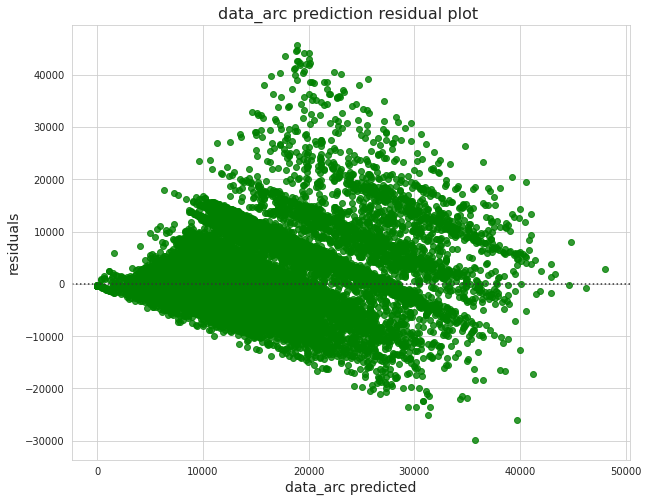

In [ ]:
#plotting residuals
plt.figure(figsize=(10,8))
k = sns.residplot(x=y_pred_train_da, y=(y_train_da-y_pred_train_da),robust=True, color='green')
plt.title("data_arc prediction residual plot ", fontsize=16)
plt.xlabel('data_arc predicted', fontsize=14)
plt.ylabel('residuals', fontsize=14)
plt.show()

Observation:
- mse for data_arc prediction is 14262851.460694853, very high
- we observe here that the residuals fan out as the predicted value is increasing, this indicates that residuals don't have consant variance

Predicting for 'H'

In [ ]:
y_train_h, y_pred_train_h, y_pred_test_h, test_indices_h, mse_h = knn_imputation('H')

Mean Squared Error for train is : 0.4958146813549192


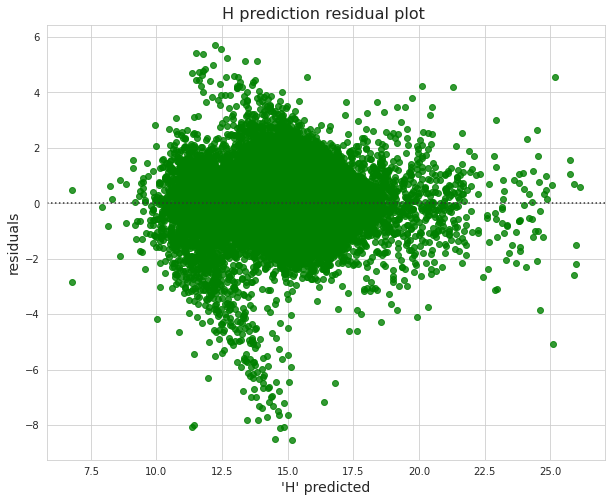

In [ ]:
#plotting residuals
plt.figure(figsize=(10,8))
k = sns.residplot(x=y_pred_train_h, y=(y_train_h-y_pred_train_h),robust=True, color='green')
plt.title("H prediction residual plot ", fontsize=16)
plt.xlabel("'H' predicted", fontsize=14)
plt.ylabel('residuals', fontsize=14)
plt.show()

Observation:
- mse for 'H' prediction is - 0.49, seems good
- the residual distribution seems to be uniform

Predicting for albedo

In [ ]:
y_train_albedo, y_pred_train_albedo, y_pred_test_albedo, test_indices_albedo, mse_albedo = knn_imputation('albedo')

Mean Squared Error for train is : 0.005029253208853607


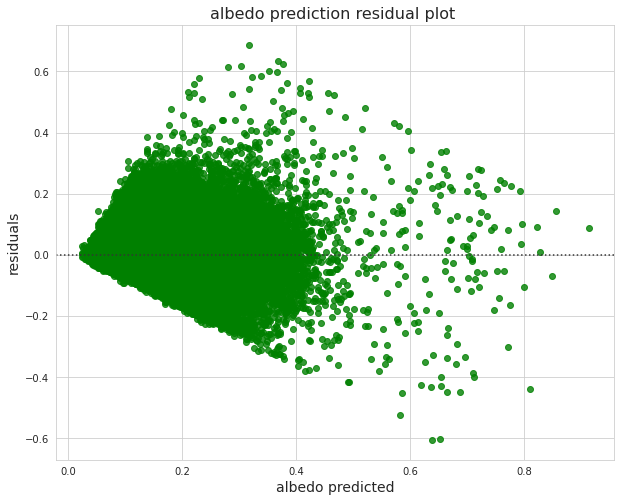

In [ ]:
#plotting residuals
plt.figure(figsize=(10,8))
k = sns.residplot(x=y_pred_train_albedo, y=(y_train_albedo-y_pred_train_albedo),robust=True, color='green')
plt.title("albedo prediction residual plot ", fontsize=16)
plt.xlabel("albedo predicted", fontsize=14)
plt.ylabel('residuals', fontsize=14)
plt.show()

Observation:
- mse(0.005) for albedo prediction looks good
- residuals errors seems not to be constant

## Summary:

- Features with missing data were - 'H', 'albedo', 'data_arc'
  - **for 'H': 0.8 %**
  - **for 'albedo':0.8%**
  - **for 'data_arc':0.019%**

- Experimented with missing values imputation strategies:
    - Simple imputer - mean and median startegy
    - Iterative imputer
    - KNN imputer


- **Conclusion** : As per the domain info - https://cneos.jpl.nasa.gov/tools/ast_size_est.html, we see that diameter value is very sensitive to changes in 'H', and 'albedo
Knowing this fact, imputing with a mean, median, or constant value won’t make sense. For albedo, it might sound ok because the expert assumed albedo value 0.14 is close to our mean albedo value 0.13. But the above resource page also states “an error in the assumed albedo can result in a significantly erroneous diameter”
Hence, it seems more reasonable to impute ‘H’ and albedo based on Nearest Neighbors approach. Using same technique for data_arc as well.

**So, here we decide to go with KNNImputer method**


In [ ]:
#final imputed and onehot encoded data
X_train_imp_df = X_train_knn_imp.copy()
X_test_imp_df = X_test_knn_imp.copy()

In [ ]:
#saving the final dataframe
save_to_csv(X_train_imp_df, 'X_train_imp_df')
save_to_csv(X_test_imp_df, 'X_test_imp_df')

In [ ]:
X_train_imp_df.head(3)

,H,albedo,epoch,e,a,q,i,ad,n,tp,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,14.73,0.100,2459800.5,0.0437,3.103,2.967,8.63,3.24,0.1803,2459704.30,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,17.33,0.071,2459800.5,0.1538,2.988,2.529,12.74,3.45,0.1908,2459459.77,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,14.40,0.207,2459800.5,0.0393,3.098,2.976,11.80,3.22,0.1808,2459605.94,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
